# Instructions


Make sure that the runtime is set to GPU to train the model faster.
Then upload the zipped files (food jpegs and their json maskes) and run the below cells in order and it should work.






# Unzip folders after uploading them to the colab environment

In [28]:
import zipfile

zip_path = '/content/Images.zip' #path in google drive environment
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [24]:
zip_path = '/content/masks.zip' # path in google drive environment
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [12]:
zip_path = '/content/Organic Pictures.zip' # path in google drive environment
extract_path = '/content/dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Image Processing and Preparation

In [37]:
import os
import json
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

class BananaSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_filenames = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.image_filenames)

    def create_mask_from_json(self, json_path, image_size):
        # Create a blank mask with all zeros (background)
        mask = Image.new('L', image_size, 0)
        draw = ImageDraw.Draw(mask)

        with open(json_path, 'r') as f:
            data = json.load(f)

            # Draw polygons for each class
            for shape in data['shapes']:
                label = shape['label'].lower()
                points = shape['points']
                polygon = [(int(point[0]), int(point[1])) for point in points]

                if label == 'banana':
                    draw.polygon(polygon, outline=1, fill=1)  # Class 1: Banana
                elif label == 'thumb':
                    draw.polygon(polygon, outline=2, fill=2)  # Class 2: Thumb
                elif label == 'apple':
                    draw.polygon(polygon, outline=3, fill=3)  # Class 3: Apple

        return mask

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Match corresponding JSON file
        json_name = os.path.splitext(img_name)[0] + '.json'
        json_path = os.path.join(self.masks_dir, json_name)

        if not os.path.exists(json_path):
            raise FileNotFoundError(f"Mask file {json_path} not found for image {img_name}")

        mask = self.create_mask_from_json(json_path, image.size)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, torch.tensor(mask, dtype=torch.long)


# Building the Neural Network

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class BananaSegmentationModelUpdated(nn.Module):
    def __init__(self):
        super(BananaSegmentationModelUpdated, self).__init__()

        # Initialize ResNet34 and use all layers up to the final convolutional block
        resnet = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4  # Include the final layer to get 512 channels
        )

        # Decoder layers
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Final convolution layer to produce the segmentation mask
        self.final_conv = nn.Conv2d(64, 4, kernel_size=1)  # 3 output channels (background, banana, thumb, apple)


    def forward(self, x):
        # Encoder path
        e1 = self.encoder[0](x)      # Initial conv1 + bn1 + relu
        e2 = self.encoder[4](e1)     # First ResNet block
        e3 = self.encoder[5](e2)     # Second ResNet block
        e4 = self.encoder[6](e3)     # Third ResNet block
        encoded = self.encoder[7](e4)  # Final ResNet block

        # Decoder path
        d4 = self.up1(encoded)                    # Upsample encoded feature map
        d4 = torch.cat([d4, e4], dim=1)           # Skip connection with e4
        d4 = self.conv1(d4)

        d3 = self.up2(d4)
        d3 = torch.cat([d3, e3], dim=1)           # Skip connection with e3
        d3 = self.conv2(d3)

        d2 = self.up3(d3)
        d2 = torch.cat([d2, e2], dim=1)           # Skip connection with e2
        d2 = self.conv3(d2)

        d1 = self.up4(d2)
        d1 = torch.nn.functional.interpolate(d1, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)           # Skip connection with e1
        d1 = self.conv4(d1)

        # Final layer to get segmentation mask
        output = self.final_conv(d1)
        outputs = torch.nn.functional.interpolate(output, size=(128, 128), mode='bilinear', align_corners=False)

        return outputs

# Training the Model

In [40]:
# Directory paths
images_dir = r"/content/dataset/Images"
masks_dir = r"/content/dataset/masks"


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# Initialize dataset and dataloaders
dataset = BananaSegmentationDataset(images_dir, masks_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BananaSegmentationModelUpdated().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # Output shape: [batch_size, num_classes, height, width]
            masks = masks.squeeze(1)  # Remove channel dimension (from [batch_size, 1, height, width] to [batch_size, height, width])

            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

train_model()


<ipython-input-37-03d24ecc4047>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


Epoch [1/20], Loss: 0.0314
Epoch [2/20], Loss: 0.0000
Epoch [3/20], Loss: 0.0000
Epoch [4/20], Loss: 0.0000
Epoch [5/20], Loss: 0.0000
Epoch [6/20], Loss: 0.0000
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.0000
Epoch [9/20], Loss: 0.0000
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


# Generate Predicted Mask and Visualize

<ipython-input-37-03d24ecc4047>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


TypeError: Invalid shape (1, 128, 128) for image data

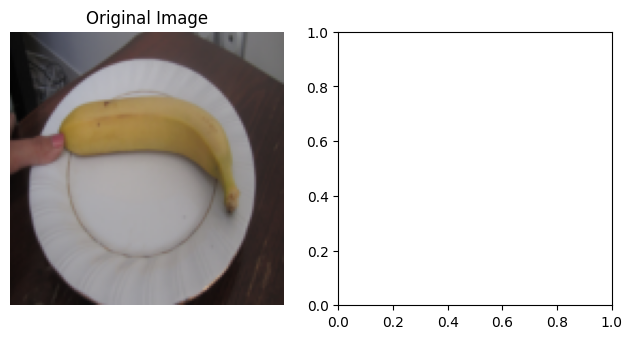

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_predicted_mask(model, dataset, device):
    """
    Generate a predicted segmentation mask for a sample image.

    Args:
        model (torch.nn.Module): The trained segmentation model.
        dataset (torch.utils.data.Dataset): The dataset containing the images and masks.
        device (torch.device): The device to run the model on.

    Returns:
        torch.Tensor: The predicted segmentation mask.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Select a sample from the dataset
        image, true_mask = val_dataset[2]  # Change the index for other samples if needed
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Generate the model's prediction
        output = model(image)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # Convert logits to class labels

    return predicted_mask, image, true_mask

def visualize_predictions(image, true_mask, predicted_mask):
    """
    Visualize the input image, ground truth mask, and predicted mask.

    Args:
        image (torch.Tensor): The input image.
        true_mask (torch.Tensor): The ground truth mask.
        predicted_mask (torch.Tensor): The predicted mask from the model.
    """
    # Move tensors to CPU and convert to NumPy arrays for visualization
    image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
    image = (image * 255).astype(np.uint8)  # Scale to 0-255 for visualization
    true_mask = true_mask.cpu().numpy()  # Convert ground truth mask to NumPy
    predicted_mask = predicted_mask.cpu().numpy()  # Convert predicted mask to NumPy

    # Plot the results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate the predicted mask
predicted_mask, image, true_mask = generate_predicted_mask(model, dataset, device)

# Visualize the input image, ground truth mask, and predicted mask
visualize_predictions(image, true_mask, predicted_mask)


# How to estimate calories
1. Calculate the number of pixels in the thumb manually using the known dimensions of it. This gives us a constant.
2. Calculate the pixel ratio between the thumb and the banana.
3. The ratio of pixels will be the same as the ratio of centimeters so use that to get the surface area of the banana in centimeters.
4. Assume a constant depth for the banana and calculate the volume by $Volume = SA* Depth$
5. We know the density of a banana: $1.15\frac{g}{cm^3}$
6. Rearranging the formula for density we get $g = Density*Volume$ and we know both of these values
7. Finally this gives us the number of grams in the banana and we know the number of calories per gram so we can easliy convert it.


Dimensions of the thumb are:
$5cm$ by $1.2cm$

In [45]:
# Constants
thumb_known_sa = 6.5 * 2.5  # Surface area of thumb in cm² (known dimensions)
banana_density = 1.15  # g/cm³
banana_cal_per_gram = 1  # Calories per gram of banana
banana_assumed_depth = 3  # Assumed depth of the banana in cm

def calculate_pixel_ratio(segmentation_mask, thumb_class, banana_class):
    """
    Calculate the pixel ratio between the thumb and banana from the segmentation mask.

    Args:
        segmentation_mask (torch.Tensor): The segmentation mask output from the model.
        thumb_class (int): The class index for the thumb in the segmentation mask.
        banana_class (int): The class index for the banana in the segmentation mask.

    Returns:
        float: The pixel ratio of thumb to banana.
    """
    thumb_pixels = torch.sum(segmentation_mask == thumb_class).item()
    banana_pixels = torch.sum(segmentation_mask == banana_class).item()

    if banana_pixels == 0:
        return float('inf')  # Avoid division by zero
    else:
        pixel_ratio = thumb_pixels / banana_pixels

    return pixel_ratio

def calculate_banana_calories(segmentation_mask, thumb_class, banana_class):
    """
    Estimate the number of calories in the banana using the segmentation mask.

    Args:
        segmentation_mask (torch.Tensor): The segmentation mask output from the model.
        thumb_class (int): The class index for the thumb in the segmentation mask.
        banana_class (int): The class index for the banana in the segmentation mask.

    Returns:
        float: Estimated number of calories in the banana.
    """
    # Step 1: Calculate the pixel ratio
    pixel_ratio = calculate_pixel_ratio(segmentation_mask, thumb_class, banana_class)

    if pixel_ratio == float('inf'):
        print("No banana detected in the segmentation mask.")
        return 0

    # Step 2: Calculate the surface area of the banana in cm²
    banana_sa = thumb_known_sa / pixel_ratio

    # Step 3: Calculate the volume of the banana in cm³
    banana_volume = banana_sa * banana_assumed_depth

    # Step 4: Calculate the mass of the banana in grams
    banana_mass = banana_density * banana_volume

    # Step 5: Calculate the calories of the banana
    banana_calories = banana_mass * banana_cal_per_gram

    return banana_calories

# Example usage
# Assuming `predicted_mask` is the segmentation mask output from the model
thumb_class = 2  # Class index for the thumb
banana_class = 1  # Class index for the banana

calories = calculate_banana_calories(predicted_mask, thumb_class, banana_class)
print(f"Estimated calories in the banana: {calories:.2f} kcal")


No banana detected in the segmentation mask.
Estimated calories in the banana: 0.00 kcal


# Predicting organic photos

## Load Image


Available Images:
0: PXL_20241124_215535163.jpg
1: PXL_20241124_221937216.jpg
2: PXL_20241124_222014896.jpg
3: PXL_20241124_221926265.jpg


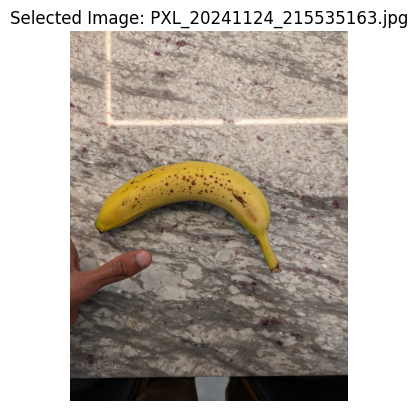

In [46]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = r"/content/dataset/Organic Pictures"  # Adjust path as needed for your Colab setup

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(dataset_dir) if f.lower().endswith(('jpg', 'png', 'jpeg'))]

# Print indexed list of images
print("Available Images:")
for idx, filename in enumerate(image_files):
    print(f"{idx}: {filename}")

# Function to load an image by index
def load_image_by_index(index):
    if index < 0 or index >= len(image_files):
        raise IndexError("Index out of range.")
    image_path = os.path.join(dataset_dir, image_files[index])
    return image_path, Image.open(image_path)

# Example usage
# Select an image by index
image_index = 0  # Replace with desired index
image_path, image = load_image_by_index(image_index)

# Display the selected image
plt.imshow(image)
plt.title(f"Selected Image: {os.path.basename(image_path)}")
plt.axis("off")
plt.show()


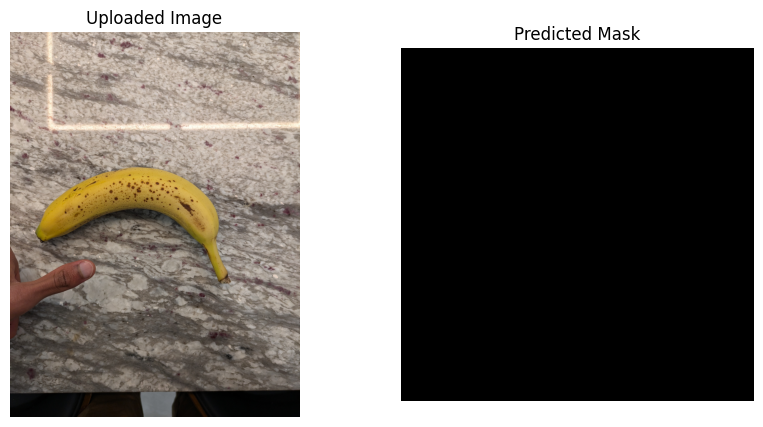

No banana detected in the segmentation mask.
Estimated calories in the banana: 0.00 kcal


In [47]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

def process_and_predict(image_path, model, device):
    """
    Process an uploaded image and generate a predicted segmentation mask.

    Args:
        image_path (str): Path to the uploaded image.
        model (torch.nn.Module): The trained segmentation model.
        device (torch.device): The device to run the model on.

    Returns:
        torch.Tensor: The predicted segmentation mask.
    """

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transformed_image = TF.resize(image, (224, 224))
    transformed_image = TF.to_tensor(transformed_image).unsqueeze(0).to(device)

    # Generate the prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(transformed_image)
        predicted_mask = torch.argmax(output, dim=1).squeeze(0)  # Convert logits to class labels

    return image, predicted_mask

def visualize_uploaded_image(image, predicted_mask):
    """
    Visualize the uploaded image and the predicted segmentation mask.

    Args:
        image (PIL.Image.Image): The original image.
        predicted_mask (torch.Tensor): The predicted segmentation mask.
    """
    predicted_mask = predicted_mask.cpu().numpy()  # Convert to NumPy for visualization

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Uploaded Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

image_index = 0  # Change this to test different images
image_path, image = load_image_by_index(image_index)

# Process the image through the model
uploaded_image, predicted_mask = process_and_predict(image_path, model, device)

# Visualize the result
visualize_uploaded_image(uploaded_image, predicted_mask)

# Calculate and display calories
calories = calculate_banana_calories(predicted_mask, thumb_class=2, banana_class=1)
print(f"Estimated calories in the banana: {calories:.2f} kcal")
